In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.arima import ARIMA, AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError, MeanSquaredScaledError
from math import sqrt, ceil, floor

In [2]:
# import dataset from csv file
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

# Evaluación de los modelos

In [ ]:
df_auto_arima = pd.read_csv('../Data/ARIMA_best_models.csv', index=False)

In [11]:
# importar ../Data/DatosCicloAprovisionamiento.xlsx
df_ciclo = pd.read_excel('../Data/DatosCicloAprovisionamiento.xlsx')
df_ciclo = df_ciclo.sort_values(by=['sku']).reset_index(drop=True)
df_ciclo = df_ciclo.rename(columns={'sku': 'idSku'})
df_ciclo['ciclo_aprovisionamiento'] = df_ciclo['diasEntrePedidos'] + df_ciclo['diasLeadtime']
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento
0,1,18,2,20
1,2,28,4,32
2,3,28,2,30
3,4,14,2,16
4,5,14,4,18


In [ ]:
skus = train['idSku'].unique()
results = pd.DataFrame(columns=['idSku', 'target', 'prediction'])

for s in skus:
    ciclo = df_ciclo[df_ciclo['idSku'] == s]['ciclo_aprovisionamiento'].values[0]
    pasos = list(range(1, ciclo + 1))
    # get order and seasonal_order
    order = df_auto_arima[df_auto_arima['idSku'] == s]['order'].values[0]
    seasonal_order = df_auto_arima[df_auto_arima['idSku'] == s]['seasonal_order'].values[0]
    # get train and test data
    train_s = train[train['idSku'] == s]
    test_s = test[test['idSku'] == s]
    train_s = train_s[['idSecuencia', 'udsVenta']]
    test_s = test_s[['idSecuencia', 'udsVenta']]
    # create an emptey dataframe with columns idSecuencia, udsVenta_ciclo, pred_ciclo
    pediccion_agg = pd.DataFrame(columns=['idSecuencia', 'udsVenta_ciclo', 'pred_ciclo'])
    # fit model
    sarima = ARIMA(order=order, seasonal_order=seasonal_order, suppress_warnings=True)
    while len(test_s) >= ciclo:
        try:
            sarima.fit(train_s['udsVenta'])
            pred = sarima.predict(fh=pasos).round().astype(int).tolist()
        except:
            sarima.fit(train_s_ant['udsVenta'])
            sarima.update(train_s['udsVenta'])
            pred = sarima.predict(fh=pasos).round().astype(int).tolist()
        pediccion = test_s.head(ciclo)
        pediccion['pred'] = pred

        udsVenta_ciclo = pediccion['udsVenta'].sum()
        pred_ciclo = pediccion['pred'].sum()
        min_idSecuencia = pediccion['idSecuencia'].min()
        pediccion_agg = pediccion_agg.append({'idSecuencia': min_idSecuencia, 'udsVenta_ciclo': udsVenta_ciclo, 'pred_ciclo': pred_ciclo}, ignore_index=True)

        train_s_ant = train_s.copy()
        # substract the firts value of test_s and add to the end of train_s
        train_s = train_s.append(test_s.iloc[0])
        train_s = train_s.reset_index(drop=True)

        test_s = test_s.drop(test_s.index[0])
        test_s = test_s.reset_index(drop=True)
    
    target = pediccion_agg['udsVenta_ciclo'].tolist()
    prediction = pediccion_agg['pred_ciclo'].tolist()
    results = results.append({'idSku': s, 'target': target, 'prediction': prediction}, ignore_index=True)


In [13]:
results.head(50)

,idSku,target,prediction
0,1,"[264, 276, 249, 252, 261, 273, 291, 297, 312, ...","[285, 296, 300, 288, 279, 270, 269, 269, 282, ..."
1,2,"[486, 495, 486, 507, 495, 498, 507, 498, 504, ...","[427, 435, 452, 440, 420, 423, 410, 432, 437, ..."
2,3,"[246, 264, 255, 254, 269, 260, 248, 254, 260, ...","[229, 229, 232, 242, 241, 229, 238, 240, 240, ..."
3,4,"[105, 114, 123, 123, 123, 117, 99, 102, 102, 1...","[139, 141, 131, 136, 130, 134, 136, 133, 136, ..."
4,5,"[33, 42, 42, 51, 51, 72, 90, 102, 111, 138, 13...","[156, 171, 157, 154, 136, 134, 130, 131, 147, ..."
5,6,"[69, 84, 75, 78, 99, 114, 132, 132, 144, 141, ...","[115, 123, 109, 112, 106, 90, 96, 104, 100, 10..."
6,7,"[183, 195, 189, 177, 174, 174, 162, 168, 183, ...","[196, 214, 206, 219, 216, 207, 203, 202, 219, ..."
7,8,"[62, 77, 79, 71, 65, 60, 56, 51, 51, 50, 50, 4...","[74, 77, 79, 73, 67, 69, 74, 75, 78, 81, 73, 6..."
8,9,"[96, 108, 114, 132, 126, 116, 110, 116, 134, 1...","[61, 64, 64, 65, 73, 76, 67, 62, 66, 77, 80, 7..."
9,10,"[82, 91, 90, 81, 69, 72, 75, 67, 79, 85, 85, 7...","[71, 73, 74, 76, 71, 73, 69, 72, 75, 76, 79, 7..."


In [ ]:
# RMSE: Root Mean Squared Error
# MAPE: Mean Absolute Percentage Error
# MASE: Mean Absolute Scaled Error
# SMAPE: Symmetric Mean Absolute Percentage Error
# RMSSE: Root Mean Squared Scaled Error

results['RMSE'] = np.nan
results['MAPE'] = np.nan
results['MASE'] = np.nan
results['SMAPE'] = np.nan
results['RMSSE'] = np.nan

rmse = MeanSquaredError(square_root=True)
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()
smape = MeanAbsolutePercentageError(symmetric=True)
rmsse = MeanSquaredScaledError(square_root=True)

# calculate rmse for each sku and append to results dataframe
for i in range(0, 50):
    t = pd.Series(results['target'][i])
    p = pd.Series(results['prediction'][i])
    y_train = train[train['idSku'] == i+1]['udsVenta']
    results['RMSE'][i] = rmse(t, p)
    results['MAPE'][i] = mape(t, p)
    results['MASE'][i] = mase(t, p, y_train=y_train)
    results['SMAPE'][i] = smape(t, p)
    results['RMSSE'][i] = rmsse(t, p, y_train=y_train)

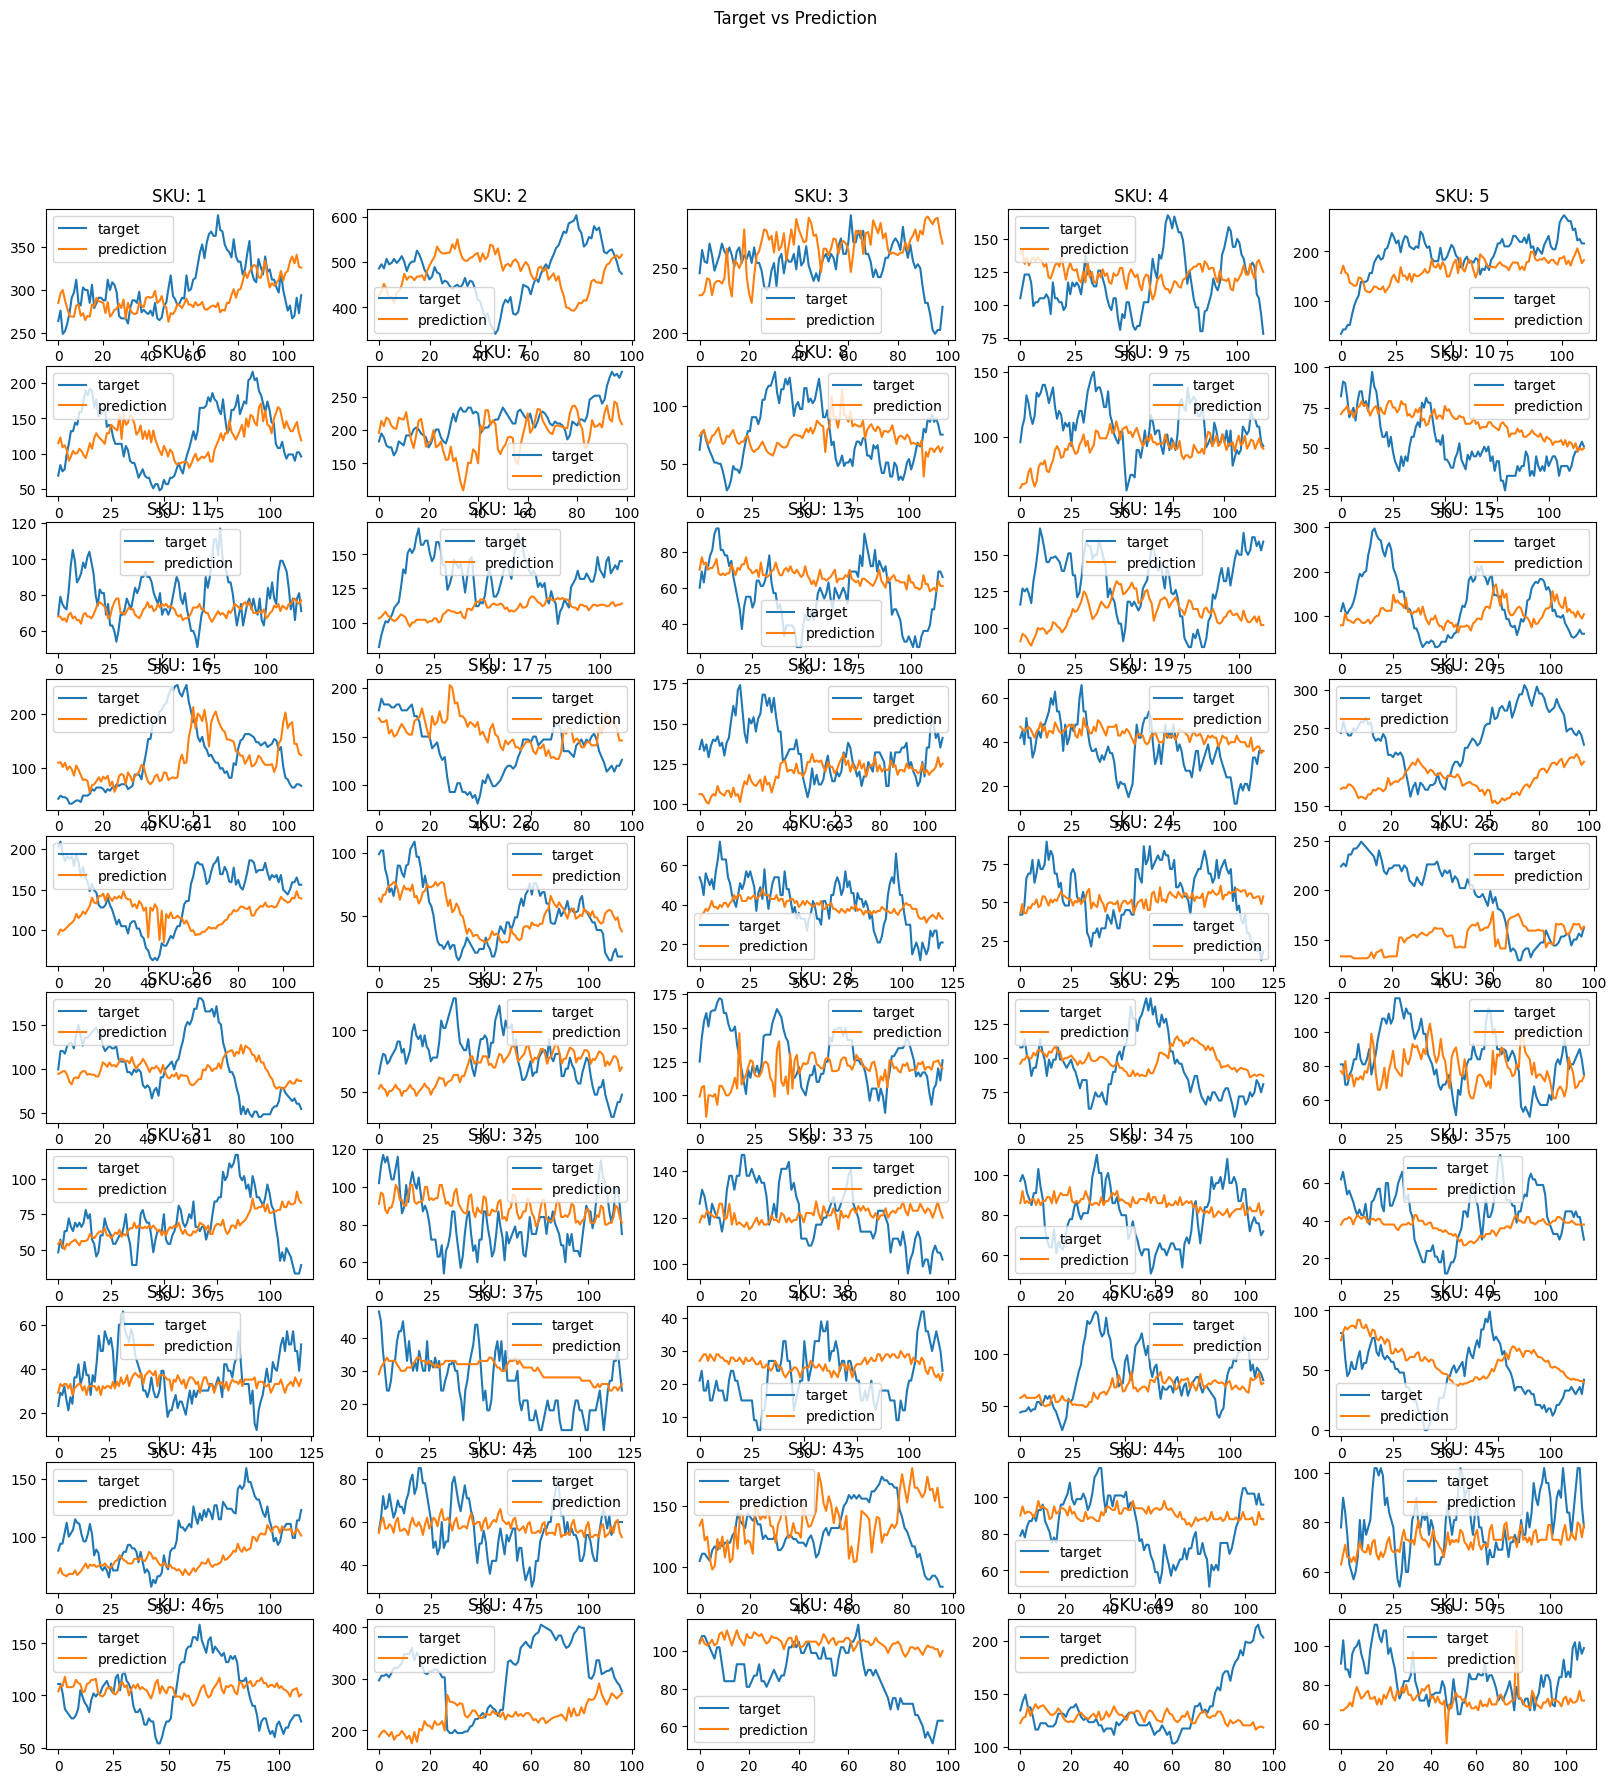

In [27]:
# make 50 subplots in a 10x5 grid and plot the target and prediction
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
fig.suptitle('Target vs Prediction')
for i in range(10):
    for j in range(5):
        axs[i, j].plot(results['target'][i*5+j], label='target')
        axs[i, j].plot(results['prediction'][i*5+j], label='prediction')
        axs[i, j].legend()
        axs[i, j].set_title('SKU: ' + str(i*5+j+1))
plt.show()

In [28]:
# get the metrics of the results dataframe
metrics = results[['RMSE', 'MAPE', 'MASE', 'SMAPE', 'RMSSE']]

# get the mean of each metric
metrics_mean = metrics.mean()
metrics_mean

RMSE     3.221145e+01
MAPE     9.238153e+13
MASE     4.557127e+00
SMAPE    2.554998e-01
RMSSE    4.172260e+00
dtype: float64

In [29]:
df_precio = pd.read_excel('../Data/DatosPrecioMedio.xlsx')
df_precio = df_precio.rename(columns={'idSkuIta': 'idSku'})
df_precio = df_precio.sort_values(by=['idSku']).reset_index(drop=True)
df_precio.head()

,idSku,eurPrecioMedio
0,1,1.370002
1,2,1.370002
2,3,1.370002
3,4,1.370002
4,5,1.370002


In [30]:
df_ciclo = df_ciclo.merge(df_precio, on='idSku', how='inner')
df_ciclo = df_ciclo.merge(results[['idSku', 'RMSE']], on='idSku', how='inner')
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE
0,1,18,2,20,1.370002,37.487490
1,2,28,4,32,1.370002,91.340419
2,3,28,2,30,1.370002,30.200341
3,4,14,2,16,1.370002,26.620240
4,5,14,4,18,1.370002,53.451418


In [34]:
factor = 1.64
df_ciclo['stock_seguridad'] = df_ciclo.apply(lambda x: ceil(factor * x['RMSE'] * sqrt(x['ciclo_aprovisionamiento'])), axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE,stock_seguridad
0,1,18,2,20,1.370002,37.487490,275
1,2,28,4,32,1.370002,91.340419,848
2,3,28,2,30,1.370002,30.200341,272
3,4,14,2,16,1.370002,26.620240,175
4,5,14,4,18,1.370002,53.451418,372


In [35]:
df_ciclo['coste_stock_diario'] = df_ciclo.apply(lambda x: 0.05 * x['eurPrecioMedio'] * x['stock_seguridad'], axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE,stock_seguridad,coste_stock_diario
0,1,18,2,20,1.370002,37.487490,275,18.837522
1,2,28,4,32,1.370002,91.340419,848,58.088067
2,3,28,2,30,1.370002,30.200341,272,18.632021
3,4,14,2,16,1.370002,26.620240,175,11.987514
4,5,14,4,18,1.370002,53.451418,372,25.482029


In [36]:
coste_stock_diario_total = df_ciclo['coste_stock_diario'].sum().round(2)
coste_stock_diario_anual = coste_stock_diario_total * 365

print('Coste stock total diario: {}€'.format(coste_stock_diario_total))
print('Coste stock total anual: {}€'.format(coste_stock_diario_anual))

Coste stock total diario: 2048.09€
Coste stock total anual: 747552.8500000001€
